In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.feather as feather
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from itertools import combinations
from sklearn.inspection import permutation_importance
from scipy.stats import f_oneway
from collections import defaultdict

warnings.filterwarnings('ignore')

Prepared Data for Robustness Checks from random sample of banks + the 3 pre-designated banks

In [116]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

# Path to your Feather file
file_path_df = 'df_train.feather'
file_path_samples = 'df_samples.feather'

# Read the Feather files into DataFrames
df = pd.DataFrame(feather.read_feather(file_path_df))
df_samples = pd.DataFrame(feather.read_feather(file_path_samples))

df_samples



,name,date,year,quarter,total_deposits,gdp,cpi,unemployment_rate,fed_fund_rate,treasury_10yr_constant_maturity_rate,private_domestic_investment,private_domestic_investment_excl_iva_ccadj,fed_govt_expenditures,state_local_govt_expenditures,net_exports_good_services,housing_starts,new_one_family_houses_sold,case_shiller_us_national_home_price_index,advance_real_retail_food_services_sales,industrial_production_index,disposable_personal_income,retail_food_services_sales,personal_savings_rate,umich_consumer_sentiment_index,household_debt_service_payments_pct_disposable_income,credit_card_delinquency_rate,consumer_credit_owned_securitized_outstanding,cpi_urban_consumers_less_food_energy,avg_hrly_earnings_production_nonsupervisory_employees,real_median_household_income,pce,total_vehicle_sales,total_assets,total_interest_expense_quarterly,non_interest_expense_quarterly,debt_securities_maturity_1yr_or_less,net_income_quarterly,category
0,BANK OF AMERICA CORP,2000-03-31,2000,1,-0.286872,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053355,-0.188762,-0.105106,-0.040430,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.291806,-0.019789,-0.260049,-0.252056,-0.207356,large
1,INDEPENDENT CMTY BCORP INC,2000-03-31,2000,1,-0.353351,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053355,-0.188762,-0.105106,-0.040430,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.379454,-0.136900,-0.337921,-0.298194,-0.297860,small
2,MILLEDGEVILLE BCORP INC,2000-03-31,2000,1,-0.353350,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053355,-0.188762,-0.105106,-0.040430,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.379454,-0.136898,-0.337925,-0.298191,-0.297859,small
3,SJN BANC CO,2000-03-31,2000,1,-0.353351,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053355,-0.188762,-0.105106,-0.040430,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.379455,-0.136899,-0.337926,-0.298192,-0.297859,small
4,TORONTO-DOMINION BANK THE,2000-03-31,2000,1,-0.352869,-0.172706,-0.185839,-0.121974,0.560238,0.509916,-0.152421,-0.065298,-0.225582,-0.285041,0.224295,0.146654,0.125720,-0.245369,-0.086721,-0.053355,-0.188762,-0.105106,-0.040430,0.253748,0.039778,0.143002,-0.300376,-0.166460,-0.209258,-0.01463,NaN,0.120187,-0.379042,-0.136156,-0.337802,-0.278633,-0.297785,intermediate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,INDEPENDENT CMTY BCORP INC,2023-12-31,2023,4,-0.353347,0.215363,0.265523,-0.135487,0.541890,0.230637,0.266163,NaN,0.295290,0.371136,-0.167703,0.032267,-0.020428,0.434906,-0.046070,0.053679,0.200468,0.195843,-0.056055,-0.176609,-0.094555,-0.053453,0.391813,0.257734,0.321299,NaN,0.177315,-0.002959,-0.379446,-0.136891,-0.337913,-0.298194,-0.297859,small
696,MIDDLESEX BCORP MHC,2023-12-31,2023,4,-0.352910,0.215363,0.265523,-0.135487,0.541890,0.230637,0.266163,NaN,0.295290,0.371136,-0.167703,0.032267,-0.020428,0.434906,-0.046070,0.053679,0.200468,0.195843,-0.056055,-0.176609,-0.094555,-0.053453,0.391813,0.257734,0.321299,NaN,0.177315,-0.002959,-0.379000,-0.136501,-0.337638,-0.296907,-0.297902,small
697,MILLEDGEVILLE BCORP INC,2023-12-31,2023,4,-0.353341,0.215363,0.265523,-0.135487,0.541890,0.230637,0.266163,NaN,0.295290,0.371136,-0.167703,0.032267,-0.020428,0.434906,-0.046070,0.053679,0.200468,0.195843,-0.056055,-0.176609,-0.094555,-0.053453,0.391813,0.257734,0.321299,NaN,0.177315,-0.002959,-0.379444,-0.136887,-0.337922,-0.298189,-0.297850,small
698,SJN BANC CO,2023-12-3

Though there was very little difference between the models, ultimately Random Forest Regression was found to be the best model. Using previously preprocessed data from before we will test the robustness of the model against the banks we previously set aside. 

Run each specific bank through the model.

In [117]:
df = df.loc[:, ['category'
                        , 'date'
                        , 'year'
                        , 'quarter'
                        , 'total_deposits'
                        , 'cpi'
                        , 'fed_fund_rate'
                        , 'housing_starts'
                        , 'personal_savings_rate'
                        , 'umich_consumer_sentiment_index']]

df_samples = df_samples.loc[:, ['category'
                        , 'date'
                        , 'year'
                        , 'quarter'
                        , 'total_deposits'
                        , 'cpi'
                        , 'fed_fund_rate'
                        , 'housing_starts'
                        , 'personal_savings_rate'
                        , 'umich_consumer_sentiment_index']]
df_samples

,category,date,year,quarter,total_deposits,cpi,fed_fund_rate,housing_starts,personal_savings_rate,umich_consumer_sentiment_index
0,large,2000-03-31,2000,1,-0.286872,-0.185839,0.560238,0.146654,-0.040430,0.253748
1,small,2000-03-31,2000,1,-0.353351,-0.185839,0.560238,0.146654,-0.040430,0.253748
2,small,2000-03-31,2000,1,-0.353350,-0.185839,0.560238,0.146654,-0.040430,0.253748
3,small,2000-03-31,2000,1,-0.353351,-0.185839,0.560238,0.146654,-0.040430,0.253748
4,intermediate,2000-03-31,2000,1,-0.352869,-0.185839,0.560238,0.146654,-0.040430,0.253748
...,...,...,...,...,...,...,...,...,...,...
695,small,2023-12-31,2023,4,-0.353347,0.265523,0.541890,0.032267,-0.056055,-0.176609
696,small,2023-12-31,2023,4,-0.352910,0.265523,0.541890,0.032267,-0.056055,-0.176609
697,small,2023-12-31,2023,4,-0.353341,0.265523,0.541890,0.032267,-0.056055,-0.176609
698,small,2023-12-31,2023,4,-0.353335,0.265523,0.541890,0.032267,-0.056055,-0.176609


In [118]:
# Group by category and apply the shift function to each group
lagged_df = df.groupby('category').apply(lambda x: x.assign(total_deposits_lag1=x['total_deposits'].shift(1)))
lagged_df_samples = df_samples.groupby('category').apply(lambda x: x.assign(total_deposits_lag1=x['total_deposits'].shift(1)))

# Drop NaN values
lagged_df = lagged_df.dropna().reset_index(drop=True)
lagged_df_samples = lagged_df_samples.dropna().reset_index(drop=True)
lagged_df_samples

,category,date,year,quarter,total_deposits,cpi,fed_fund_rate,housing_starts,personal_savings_rate,umich_consumer_sentiment_index,total_deposits_lag1
0,intermediate,2000-06-30,2000,2,-0.352995,-0.177713,0.647394,0.142254,-0.046680,0.228748,-0.352869
1,intermediate,2000-06-30,2000,2,-0.352888,-0.177713,0.647394,0.142254,-0.046680,0.228748,-0.352995
2,intermediate,2000-09-30,2000,3,-0.353010,-0.172838,0.726905,0.070543,-0.034180,0.220712,-0.352888
3,intermediate,2000-09-30,2000,3,-0.352877,-0.172838,0.726905,0.070543,-0.034180,0.220712,-0.353010
4,intermediate,2000-12-31,2000,4,-0.352972,-0.168938,0.722318,0.108378,-0.046680,0.198391,-0.352877
...,...,...,...,...,...,...,...,...,...,...,...
692,small,2023-12-31,2023,4,-0.353308,0.265523,0.541890,0.032267,-0.056055,-0.176609,-0.353337
693,small,2023-12-31,2023,4,-0.353347,0.265523,0.541890,0.032267,-0.056055,-0.176609,-0.353308
694,small,2023-12-31,2023,4,-0.352910,0.265523,0.541890,0.032267,-0.056055,-0.176609,-0.353347
695,small,2023-12-31,2023,4,-0.353341,0.265523,0.541890,0.032267,-0.056055,-0.176609,-0.352910


In [119]:
selected_features=['cpi','fed_fund_rate','housing_starts','personal_savings_rate','umich_consumer_sentiment_index']

Test on Multiple Models for Robustness (Ridge + Random_Forest for Comparison)

In [120]:
def run_random_forest(lagged_df, selected_features):
    """
    Run Random Forest regression for each category using future importance, evaluate the models, and pick a best model for each category after grid search.

    Args:
    - lagged_df (DataFrame): DataFrame where 'total_deposits' is the response variable, and selected_features (list): list of most independent features in the model.

    Returns:
    - dict: Dictionary containing the best model for each category and their evaluation metrics.
    """
    best_models = {}
    for category in lagged_df['category'].unique():
        df_cat = lagged_df[lagged_df['category'] == category]
        X = df_cat[selected_features]
        y = df_cat['total_deposits']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        param_grid = {
            'n_estimators': [50, 100, 150],
            'max_depth': [None, 10, 20]
        }
        grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        
        best_models[category] = {'model': best_model, 'rmse': rmse, 'r2': r2}
    
    return best_models

best_models_random_forest = run_random_forest(lagged_df, selected_features)
best_models_random_forest

{'intermediate': {'model': RandomForestRegressor(n_estimators=50, random_state=42),
  'rmse': 0.007584791766066514,
  'r2': 0.9954942143311664},
 'large': {'model': RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42),
  'rmse': 0.009462798555142867,
  'r2': 0.9985786842625077},
 'small': {'model': RandomForestRegressor(n_estimators=50, random_state=42),
  'rmse': 0.023690115814869073,
  'r2': 0.9879899316930624}}

In [121]:
# Robustness Test on Random Forest Model
random_forest={}

test_X = lagged_df_samples[selected_features]
test_y = lagged_df_samples['total_deposits']

for category, info in best_models_random_forest.items():
    model = info['model']
    
    # Filter test_X and test_y by category
    test_X = lagged_df_samples[lagged_df_samples['category'] == category][selected_features]
    test_y = lagged_df_samples[lagged_df_samples['category'] == category]['total_deposits']
    
    predictions = model.predict(test_X)
    rmse = mean_squared_error(test_y, predictions, squared=False)
    r2 = r2_score(test_y, predictions)       

    random_forest[category] = { 'rmse': rmse, 'r2': r2 }

random_forest


{'intermediate': {'rmse': 0.2371406836495739, 'r2': -404.7205019514317},
 'large': {'rmse': 0.2979506084688649, 'r2': -9.423826295327185},
 'small': {'rmse': 0.5058844096058318, 'r2': -16217489.887529293}}

In [122]:
def run_ridge_ols(lagged_df, selected_features):
    """
    Run OLS with Ridge regression for each category using future importance, evaluate the models, and pick a best model for each category after grid search.

    Args:
    - lagged_df (DataFrame): DataFrame where 'total_deposits' is the response variable, and selected_features (list): list of most independent features in the model.

    Returns:
    - dict: Dictionary containing the best model for each category and their evaluation metrics.
    """
    best_models = {}
    for category in lagged_df['category'].unique():
        df_cat = lagged_df[lagged_df['category'] == category]
        X = df_cat[selected_features]
        y = df_cat['total_deposits']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        param_grid = {'alpha': [0.01, 0.1, 1, 10]}
        grid_search = GridSearchCV(Ridge(), param_grid, cv=3, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        
        best_models[category] = {'model': best_model, 'rmse': rmse, 'r2': r2}
    
    return best_models

best_models_ridge = run_ridge_ols(lagged_df, selected_features)
best_models_ridge

{'intermediate': {'model': Ridge(alpha=0.01),
  'rmse': 0.016430116447901332,
  'r2': 0.9788571032893162},
 'large': {'model': Ridge(alpha=0.01),
  'rmse': 0.03291869222912243,
  'r2': 0.9827996801847124},
 'small': {'model': Ridge(alpha=0.01),
  'rmse': 0.04383393974508407,
  'r2': 0.9588819867359585}}

In [123]:
# Robustness Test on Ridge Regression
ridge={}

test_X = lagged_df_samples[selected_features]
test_y = lagged_df_samples['total_deposits']

for category, info in best_models_ridge.items():
    model = info['model']
    # Filter test_X and test_y by category
    test_X = lagged_df_samples[lagged_df_samples['category'] == category][selected_features]
    test_y = lagged_df_samples[lagged_df_samples['category'] == category]['total_deposits']
    
    predictions = model.predict(test_X)
    rmse = mean_squared_error(test_y, predictions, squared=False)
    r2 = r2_score(test_y, predictions)       

    ridge[category] = { 'rmse': rmse, 'r2': r2}

ridge

{'intermediate': {'rmse': 0.23704518900432847, 'r2': -404.3938069800693},
 'large': {'rmse': 0.2970077140960071, 'r2': -9.357956213919065},
 'small': {'rmse': 0.504119284936874, 'r2': -16104515.650085669}}

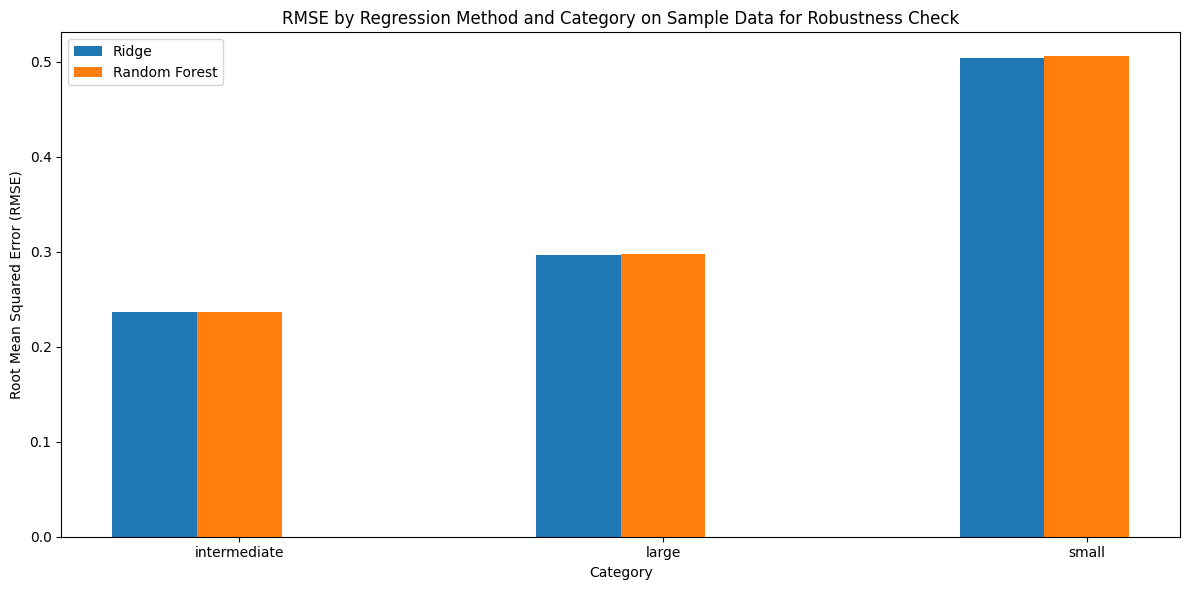

In [124]:
categories = lagged_df['category'].unique()

rmse_values = {
    'Ridge': [ridge[cat]['rmse'] for cat in categories],
    'Random Forest': [random_forest[cat]['rmse'] for cat in categories],
}

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = range(len(categories))

for i, (method, rmse) in enumerate(rmse_values.items()):
    ax.bar([x + i * bar_width for x in index], rmse, bar_width, label=method)

ax.set_xlabel('Category')
ax.set_ylabel('Root Mean Squared Error (RMSE)')
ax.set_title('RMSE by Regression Method and Category on Sample Data for Robustness Check')
ax.set_xticks([x + bar_width for x in index])
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

Conclusion: 

There isn't a huge variance between the results of th  

#### **Sensitivity Analysis** 

Random Forest Regression - Hyperparameters adjusted are n_estimators and max_depth

Ridge Regression - Hyperparameter adjusted is the alpha

In [152]:
#Random Forest Regression

n_estimators_range = [50, 100, 150, 200, 250]
max_depth_range = [None, 1, 5, 10, 20, 30]

results_random_forest_n_estimators = []
results_random_forest_max_depth = []

for category in lagged_df['category'].unique():
    df_cat = lagged_df[lagged_df['category'] == category]
    X = df_cat[selected_features]
    y = df_cat['total_deposits']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for n_estimators in n_estimators_range:

        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=10, random_state=42)  # Keeping max_depth constant
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        rmse = mean_squared_error(y_test, predictions, squared=False)
        r2 = r2_score(y_test, predictions)
        results_random_forest_n_estimators.append({'category': category, 'n_estimators': n_estimators, 'max_depth': 10, 'RMSE': rmse, 'R2': r2})

    # Repeat for max_depth variation
    for max_depth in max_depth_range:
        model = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=42)  # Keeping n_estimators constant
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        rmse = mean_squared_error(y_test, predictions, squared=False)
        r2 = r2_score(y_test, predictions)
        results_random_forest_max_depth.append({'category': category, 'n_estimators': 100, 'max_depth': max_depth, 'RMSE': rmse, 'R2': r2})

results_random_forest_n_estimators = pd.DataFrame(results_random_forest_n_estimators)
results_random_forest_max_depth = pd.DataFrame(results_random_forest_max_depth)

In [153]:
results_random_forest_n_estimators

,category,n_estimators,max_depth,RMSE,R2
0,intermediate,50,10,0.007534,0.995555
1,intermediate,100,10,0.006907,0.996263
2,intermediate,150,10,0.006732,0.996451
3,intermediate,200,10,0.007164,0.995980
4,intermediate,250,10,0.007426,0.995681
5,large,50,10,0.009463,0.998579
6,large,100,10,0.009933,0.998434
7,large,150,10,0.010311,0.998312
8,large,200,10,0.009815,0.998471
9,large,250,10,0.009600,0.998537


In [154]:
results_random_forest_max_depth

,category,n_estimators,max_depth,RMSE,R2
0,intermediate,100,NaN,0.006936,0.996233
1,intermediate,100,1.0,0.051623,0.791277
2,intermediate,100,5.0,0.007329,0.995793
3,intermediate,100,10.0,0.006907,0.996263
4,intermediate,100,20.0,0.006936,0.996233
5,intermediate,100,30.0,0.006936,0.996233
6,large,100,NaN,0.009914,0.998440
7,large,100,1.0,0.102828,0.832169
8,large,100,5.0,0.010210,0.998345
9,large,100,10.0,0.009933,0.998434


In [157]:
# Ridge Regression 

alpha_range = np.logspace(-4, 2, 10)
results_ridge = []

for category in lagged_df['category'].unique():
    df_cat = lagged_df[lagged_df['category'] == category]
    X = df_cat[selected_features]
    y = df_cat['total_deposits']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Loop over each alpha value
    for alpha in alpha_range:
        model = Ridge(alpha=alpha, max_iter=10000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        results_ridge.append({'category': category,'alpha': alpha, 'max_iter': 10000, 'RMSE': rmse, 'R2': r2})

results_ridge = pd.DataFrame(results_ridge)
results_ridge


,category,alpha,max_iter,RMSE,R2
0,intermediate,0.000100,10000,0.016411,0.978906
1,intermediate,0.000464,10000,0.016410,0.978909
2,intermediate,0.002154,10000,0.016406,0.978920
3,intermediate,0.010000,10000,0.016430,0.978857
4,intermediate,0.046416,10000,0.017340,0.976452
5,intermediate,0.215443,10000,0.027424,0.941095
6,intermediate,1.000000,10000,0.057765,0.738659
7,intermediate,4.641589,10000,0.090228,0.362376
8,intermediate,21.544347,10000,0.110357,0.046141
9,intermediate,100.000000,10000,0.118709,-0.103698


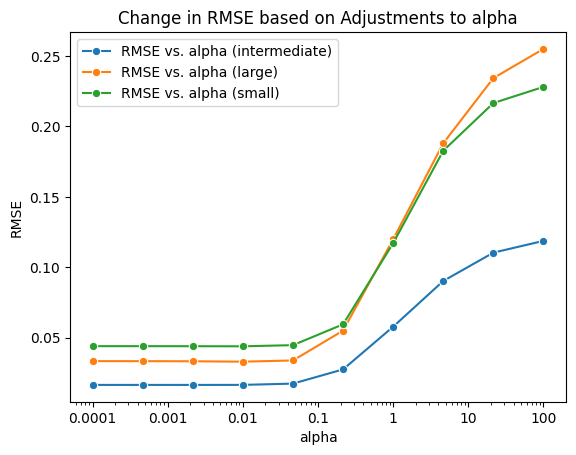

In [159]:
sns.lineplot(data=results_ridge[0:10], x='alpha', y='RMSE', marker='o', label='RMSE vs. alpha (intermediate)' )
sns.lineplot(data=results_ridge[10:20], x='alpha', y='RMSE', marker='o', label='RMSE vs. alpha (large)')
sns.lineplot(data=results_ridge[20:], x='alpha', y='RMSE', marker='o', label='RMSE vs. alpha (small)')
plt.xscale('log')
plt.xticks(ticks=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100], labels=['0.0001', '0.001', '0.01', '0.1', '1', '10', '100'])
plt.title("Change in RMSE based on Adjustments to alpha")
plt.legend()
plt.show()

Alpha is optimal at 0.01. Further increment decreases the accuracy of the model.

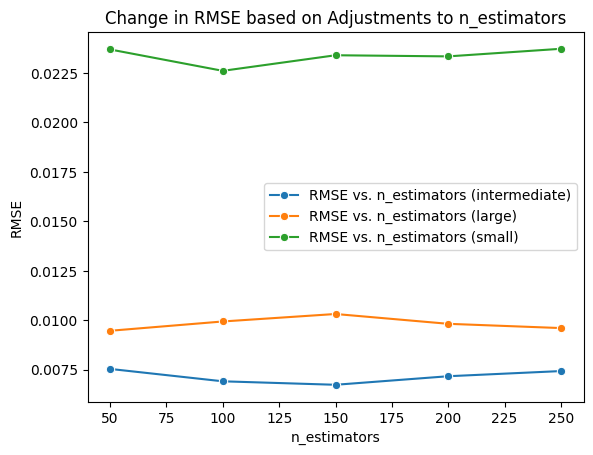

In [145]:
sns.lineplot(data=results_random_forest_n_estimators[:5], x='n_estimators', y='RMSE', marker='o', label='RMSE vs. n_estimators (intermediate)')
sns.lineplot(data=results_random_forest_n_estimators[5:10], x='n_estimators', y='RMSE', marker='o', label='RMSE vs. n_estimators (large)')
sns.lineplot(data=results_random_forest_n_estimators[10:], x='n_estimators', y='RMSE', marker='o', label='RMSE vs. n_estimators (small)')

plt.title("Change in RMSE based on Adjustments to n_estimators")
plt.legend()
plt.show()

Confirming our results for the "Best Model" hyperparameters. 

For the intermediate sized banks as n_estimators increases RMSE decreases up to around 150. After 150 the model's performance deteriorates, which indicates additional trees is detrimental and doesn't improve the model accuracy.

For the large sized banks, RMSE starts higher at 50 n_estimators compared to intermediate sized banks and increases slightly as the number of n_estimators increases to 150. However,after 150 n_estimators RMSE decreases overall, suggesting that more trees could improve the model.

For the small banks, RMSE is the highest, indicating that predictive accuracy among small banks are the lowest of the three categories. The RMSE is most optimal at 100 n_estimators.

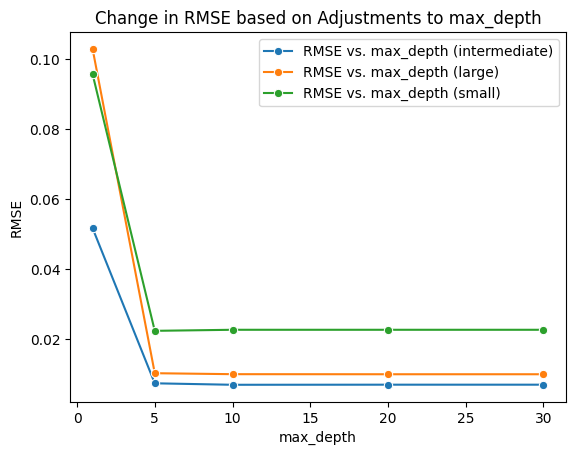

In [151]:
sns.lineplot(data=results_random_forest_max_depth[:6], x='max_depth', y='RMSE', marker='o', label='RMSE vs. max_depth (intermediate)')
sns.lineplot(data=results_random_forest_max_depth[6:12], x='max_depth', y='RMSE', marker='o', label='RMSE vs. max_depth (large)')
sns.lineplot(data=results_random_forest_max_depth[12:], x='max_depth', y='RMSE', marker='o', label='RMSE vs. max_depth (small)')

plt.title("Change in RMSE based on Adjustments to max_depth")
plt.legend()
plt.show()

The model is no longer sensitive to changes once max_depth > 5 across all bank sizes.

#### Conclusion:

Each bank size has different optimal hyperparameters for their model. Among these, predictions for intermediate size banks seem to be the most accurate. This could be attributed to lower overall variance in deposits intermediate sized banks based on total deposit amount. 

As previously shown in our data preprocessing, the vast majority of banks have much smaller asset sizes and as such we have divided and seperated them based on asset size. The # of small banks is far larger than those in intermediate; while larger banks are also far fewer. 